# State tomography
State tomography involves measuring a quantum state repeatedly in the bases given by `itertools.product(['X', 'Y', 'Z], repeat=n_qubits)`. From these measurements, we can reconstruct a density matrix $\rho$.

In [45]:
import numpy as np
from pyquil import Program, get_qc
from pyquil.gates import *

## Construct a state with a `Program`
We'll construct a two-qubit graph state by Hadamarding all qubits and then applying a controlled-Z operation across edges of our graph. In the two-qubit case, there's only one edge. 

In [46]:
qubits = [0, 1]
program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(qubits[0], qubits[1])
print(program)

H 0
H 1
CZ 0 1



## Construct a `TomographyExperiment` for state tomography
We can print this out to see the 16 measurements we will perform.

In [47]:
from forest_qcvv.tomography import generate_state_tomography_experiment
experiment = generate_state_tomography_experiment(program=program, qubits=qubits)
print(experiment)

H 0; H 1; CZ 0 1
0: (1+0j)*I→(1+0j)*I
1: (1+0j)*I→(1+0j)*X1
2: (1+0j)*I→(1+0j)*Y1
3: (1+0j)*I→(1+0j)*Z1
4: (1+0j)*I→(1+0j)*X0
5: (1+0j)*I→(1+0j)*X0X1
6: (1+0j)*I→(1+0j)*X0Y1
7: (1+0j)*I→(1+0j)*X0Z1
8: (1+0j)*I→(1+0j)*Y0
9: (1+0j)*I→(1+0j)*Y0X1
10: (1+0j)*I→(1+0j)*Y0Y1
11: (1+0j)*I→(1+0j)*Y0Z1
12: (1+0j)*I→(1+0j)*Z0
13: (1+0j)*I→(1+0j)*Z0X1
14: (1+0j)*I→(1+0j)*Z0Y1
15: (1+0j)*I→(1+0j)*Z0Z1


### Optional grouping
We can simultaneously estimate some of these observables

In [48]:
from pyquil.operator_estimation import group_experiments
print(group_experiments(experiment))

H 0; H 1; CZ 0 1
0: (1+0j)*I→(1+0j)*X1, (1+0j)*I→(1+0j)*Z0, (1+0j)*I→(1+0j)*Z0X1, (1+0j)*I→(1+0j)*I
1: (1+0j)*I→(1+0j)*Y0, (1+0j)*I→(1+0j)*Y0Y1, (1+0j)*I→(1+0j)*Y1
2: (1+0j)*I→(1+0j)*Z1, (1+0j)*I→(1+0j)*X0Z1, (1+0j)*I→(1+0j)*X0
3: (1+0j)*I→(1+0j)*X0X1
4: (1+0j)*I→(1+0j)*X0Y1
5: (1+0j)*I→(1+0j)*Y0X1
6: (1+0j)*I→(1+0j)*Y0Z1
7: (1+0j)*I→(1+0j)*Z0Y1
8: (1+0j)*I→(1+0j)*Z0Z1


## PyQuil will run the tomography programs

In [49]:
from pyquil.operator_estimation import measure_observables

qc = get_qc('2q-pyqvm')
from forest_qcvv.compilation import basic_compile
qc.compiler.quil_to_native_quil = basic_compile

results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=100_000))
results

[ExperimentResult[(1+0j)*I→(1+0j)*I: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*X1: 0.001 +- 0.0031622760790291538],
 ExperimentResult[(1+0j)*I→(1+0j)*Y1: 0.00174 +- 0.003162272873108834],
 ExperimentResult[(1+0j)*I→(1+0j)*Z1: -0.00384 +- 0.0031622543452416983],
 ExperimentResult[(1+0j)*I→(1+0j)*X0: 0.00278 +- 0.003162265440471435],
 ExperimentResult[(1+0j)*I→(1+0j)*X0X1: 0.00256 +- 0.0031622672979999653],
 ExperimentResult[(1+0j)*I→(1+0j)*X0Y1: 0.00092 +- 0.0031622763218921903],
 ExperimentResult[(1+0j)*I→(1+0j)*X0Z1: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0: -0.0005 +- 0.0031622772648836474],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0X1: 0.00502 +- 0.0031622378145863728],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0Y1: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0Z1: -0.0011 +- 0.0031622757469898168],
 ExperimentResult[(1+0j)*I→(1+0j)*Z0: -0.005 +- 0.003162238131450571],
 ExperimentResult[(1+0j)*I→(1+0j)*Z0X1: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*Z0Y1: 0.00356 +- 0.00316

In [50]:
# Half-way between conversion
from forest_qcvv.tomography import shim_pyquil_results_to_TomographyData
data = shim_pyquil_results_to_TomographyData(program=program, qubits=qubits, counts=100_000, results=results)

### We can look at a bunch of numbers...

In [51]:
from forest_qcvv.tomography import linear_inv_state_estimate
rho = linear_inv_state_estimate(data).estimate.state_point_est
rho

array([[ 0.24876 +0.00000000e+00j,  0.25025 +1.32500000e-03j,
         0.250695-4.00000000e-04j, -0.24936 +1.48500000e-03j],
       [ 0.25025 -1.32500000e-03j,  0.24874 -7.99958545e-17j,
         0.25064 +1.02500000e-03j, -0.249305+1.50000000e-04j],
       [ 0.250695+4.00000000e-04j,  0.25064 -1.02500000e-03j,
         0.24932 -3.95255719e-17j, -0.24975 -4.55000000e-04j],
       [-0.24936 -1.48500000e-03j, -0.249305-1.50000000e-04j,
        -0.24975 +4.55000000e-04j,  0.25318 +2.66736883e-18j]])

In [52]:
psi = (1/2) * np.array([1, 1, 1, -1])
rho_true = np.outer(psi, psi.T.conj())
rho_true

array([[ 0.25,  0.25,  0.25, -0.25],
       [ 0.25,  0.25,  0.25, -0.25],
       [ 0.25,  0.25,  0.25, -0.25],
       [-0.25, -0.25, -0.25,  0.25]])

### Or visualize using Hinton plots

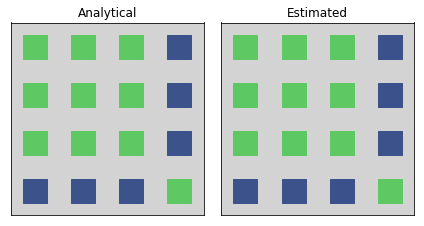

In [53]:
from matplotlib import pyplot as plt
from forest_qcvv.plotting import hinton
fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_true, ax=ax1)
hinton(rho, ax=ax2)
ax1.set_title('Analytical')
ax2.set_title('Estimated')
fig.tight_layout()

### Matrix norm between true and estimated is low

In [54]:
np.linalg.norm(rho - rho_true)

0.005321888762460097

## Fun with plotting

In [55]:
PROJ_ZERO = np.array([[1, 0], [0, 0]])
PROJ_ONE = np.array([[0, 0], [0, 1]])
ID = PROJ_ZERO + PROJ_ONE
PLUS = np.array([[1], [1]]) / np.sqrt(2)
PROJ_PLUS = PLUS @ PLUS.T.conj()
PROJ_MINUS = ID - PROJ_PLUS
Z_EFFECTS = [PROJ_ZERO, PROJ_ONE]
X_EFFECTS = [PROJ_PLUS, PROJ_MINUS]
X = PROJ_PLUS - PROJ_MINUS
Y = 1j * PROJ_PLUS - 1j * PROJ_MINUS
Z = PROJ_ZERO - PROJ_ONE

# Two qubit defs
P00 = np.kron(PROJ_ZERO, PROJ_ZERO)
P01 = np.kron(PROJ_ZERO, PROJ_ONE)
P10 = np.kron(PROJ_ONE, PROJ_ZERO)
P11 = np.kron(PROJ_ONE, PROJ_ONE)
ID_2Q = P00 + P01 + P10 + P11
ZZ_EFFECTS = [P00, P01, P10, P11]

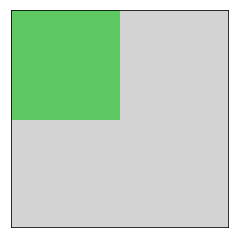

In [56]:
hinton(PROJ_ZERO, max_weight=1)

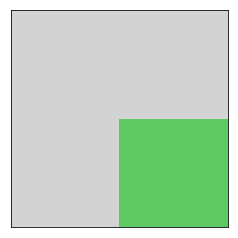

In [57]:
hinton(PROJ_ONE, max_weight=1)

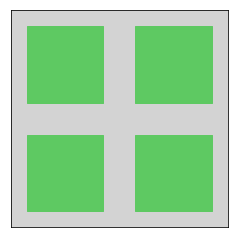

In [58]:
hinton(PROJ_PLUS, max_weight=1)

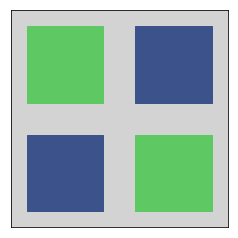

In [59]:
hinton(PROJ_MINUS, max_weight=1)

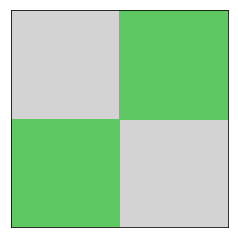

In [60]:
hinton(X, max_weight=1)

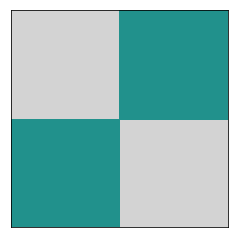

In [61]:
hinton(Y, max_weight=1) # this seems wrong

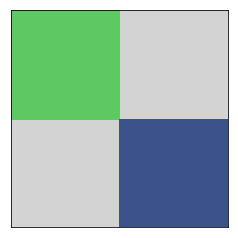

In [62]:
hinton(Z, max_weight=1)

## Linear inversion estimate

[[ 0.2488+0.j      0.2502+0.0013j  0.2507-0.0004j -0.2494+0.0015j]
 [ 0.2503-0.0013j  0.2487-0.j      0.2506+0.001j  -0.2493+0.0002j]
 [ 0.2507+0.0004j  0.2506-0.001j   0.2493-0.j     -0.2498-0.0005j]
 [-0.2494-0.0015j -0.2493-0.0002j -0.2498+0.0005j  0.2532+0.j    ]]
Purity = (1.0000283225000002-2.3245294578089215e-16j)


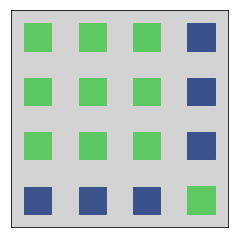

In [63]:
from forest_qcvv.tomography import linear_inv_state_estimate
rho = linear_inv_state_estimate(data).estimate.state_point_est

print(np.round(rho, 4))
print('Purity =', np.trace(rho @ rho))
hinton(rho)

## Maximum Liklihood Estimate (MLE) via diluted iterative method

In [64]:
from forest_qcvv.tomography import iterative_mle_state_estimate
est_mle, status = iterative_mle_state_estimate(data, dilution=0.5)
rho = est_mle.estimate.state_point_est
print(np.around(rho, decimals=4))
print('Purity =', np.trace(rho @ rho))

[[ 0.2497-0.j      0.2497+0.j      0.2499+0.0001j -0.2501-0.0003j]
 [ 0.2497-0.j      0.2496-0.j      0.2499+0.j     -0.2501-0.0003j]
 [ 0.2499-0.0001j  0.2499-0.j      0.2501+0.j     -0.2503-0.0002j]
 [-0.2501+0.0003j -0.2501+0.0003j -0.2503+0.0002j  0.2505+0.j    ]]
Purity = (0.9999999950036171+2.0328790734103208e-19j)


## MLE with Max Entropy constraint

In [65]:
est_max_ent, stat = iterative_mle_state_estimate(data, dilution=0.5, entropy_penalty=0.005)
rho = est_max_ent.estimate.state_point_est
print(np.around(rho, decimals=4))
print('Purity =', np.trace(rho @ rho))

[[ 0.2497-0.j      0.2497+0.j      0.2499+0.0001j -0.2501-0.0003j]
 [ 0.2497-0.j      0.2496+0.j      0.2499+0.j     -0.2501-0.0003j]
 [ 0.2499-0.0001j  0.2499-0.j      0.2501+0.j     -0.2503-0.0002j]
 [-0.2501+0.0003j -0.2501+0.0003j -0.2503+0.0002j  0.2505+0.j    ]]
Purity = (0.9999999950035885-1.0164395367051604e-19j)


## MLE with Hedging parameter

In [66]:
est_hedging, stat = iterative_mle_state_estimate(data, dilution=0.5, beta=.61)
rho = est_hedging.estimate.state_point_est
print(np.around(rho, decimals=4))
print('Purity = ', np.trace(rho @ rho))

[[ 0.2497-0.j      0.2497+0.j      0.2499+0.0001j -0.2501-0.0003j]
 [ 0.2497-0.j      0.2496+0.j      0.2499+0.j     -0.2501-0.0003j]
 [ 0.2499-0.0001j  0.2499-0.j      0.2501+0.j     -0.2503-0.0002j]
 [-0.2501+0.0003j -0.2501+0.0003j -0.2503+0.0002j  0.2505-0.j    ]]
Purity =  (0.9999999949923233+4.607859233063394e-19j)


## Project an unphysical state to the closest physical state

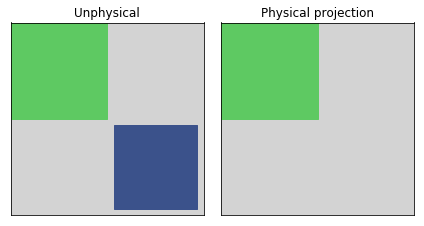

In [67]:
from forest_qcvv.tomography import project_density_matrix
rho_unphys = np.array([[1.0, 0], [0, -0.75]])
rho_phys = project_density_matrix(rho_unphys)

fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_unphys, ax=ax1)
hinton(rho_phys, ax=ax2)
ax1.set_title('Unphysical')
ax2.set_title('Physical projection')
fig.tight_layout()

In [68]:
# Test the wizard method. Example from fig 1 of maximum likelihood minimum effort 
# https://doi.org/10.1103/PhysRevLett.108.070502

eigs = np.diag(np.array(list(reversed([3.0/5, 1.0/2, 7.0/20, 1.0/10, -11.0/20]))))
phys = project_density_matrix(eigs)
np.allclose(phys, np.diag([0, 0, 1.0/5, 7.0/20, 9.0/20]))

True

# Lightweight Bootstrap for functionals of the state

In [69]:
import forest_qcvv.distance_measures as dm
from forest_qcvv.tomography import estimate_variance

In [70]:
def my_mle_estimator(data):
    return iterative_mle_state_estimate(data, dilution=0.5, entropy_penalty=0.0, beta=0.0)[0]

**Purity**

In [71]:
mle_est = estimate_variance(data, my_mle_estimator, dm.purity, n_resamples=40, project_to_physical=True)
lin_inv_est = estimate_variance(data, linear_inv_state_estimate, dm.purity, n_resamples=40, project_to_physical=True)
print(mle_est)
print(lin_inv_est)

(0.9999628309529021, 4.136212817438777e-10)
(0.9955020846807209, 1.3929914952871658e-06)


**Fidelity**

In [74]:
mle_est = estimate_variance(data, my_mle_estimator, dm.fidelity, target_state=rho_true, n_resamples=40, project_to_physical=True)
lin_inv_est = estimate_variance(data, linear_inv_state_estimate, dm.fidelity, target_state=rho_true, n_resamples=40, project_to_physical=True)
print(mle_est)
print(lin_inv_est)

Failed to find a square root.
Failed to find a square root.


ValueError: array must not contain infs or NaNs